In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

In [2]:
train = load_dataset('snli', split='train').to_pandas()
dev = load_dataset('snli', split='validation').to_pandas()
test = load_dataset('snli', split='test').to_pandas()

Reusing dataset snli (/home/eric/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Reusing dataset snli (/home/eric/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Reusing dataset snli (/home/eric/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


In [3]:
train['prem_len'] = train.premise.apply(lambda x: len(x.split(' ')))
train['hyp_len'] = train.hypothesis.apply(lambda x: len(str(x).split(' ')))

dev['prem_len'] = train.premise.apply(lambda x: len(x.split(' ')))
dev['hyp_len'] = train.hypothesis.apply(lambda x: len(str(x).split(' ')))

test['prem_len'] = train.premise.apply(lambda x: len(x.split(' ')))
test['hyp_len'] = train.hypothesis.apply(lambda x: len(str(x).split(' ')))

gold_label = {2: 'contradiction', 0: 'entailment', 1:'neutral'}
train['gold_label'] = train.label.map(gold_label)
dev['gold_label'] = dev.label.map(gold_label)
test['gold_label'] = test.label.map(gold_label)

train['len_ratio'] = train['hyp_len'] / train['prem_len'] 
dev['len_ratio'] = dev['hyp_len'] / dev['prem_len'] 
test['len_ratio'] = test['hyp_len'] / test['prem_len'] 

## Train sentence lengths

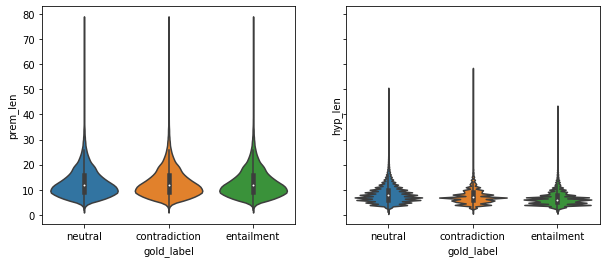

In [4]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

sns.violinplot(x="gold_label", y="prem_len", data=train, scale='count', scale_hue=False, ax=axes[0])
sns.violinplot(x="gold_label", y="hyp_len", data=train, scale='count', scale_hue=False, ax=axes[1])


Text(0, 0.5, 'len(hyp) / len(prem)')

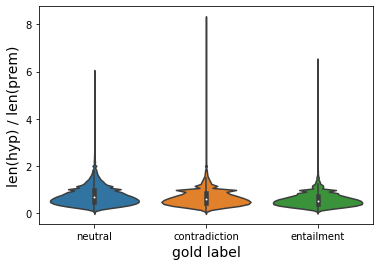

In [15]:
ax = sns.violinplot(x="gold_label", y=train['len_ratio'], data=train, scale='count', scale_hue=False)
ax.set_xlabel('gold label', fontsize=14)
ax.set_ylabel('len(hyp) / len(prem)', fontsize=14)

## dev sentence lengths

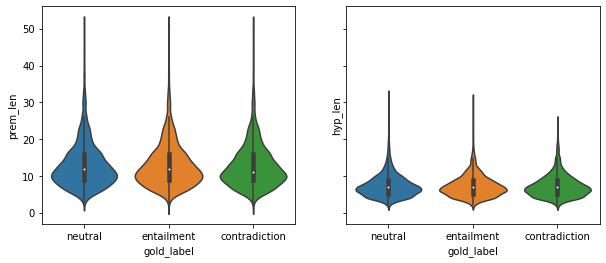

In [5]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

sns.violinplot(x="gold_label", y="prem_len", data=dev, scale='count', scale_hue=False, ax=axes[0])
sns.violinplot(x="gold_label", y="hyp_len", data=dev, scale='count', scale_hue=False, ax=axes[1])

## test sentence lengths

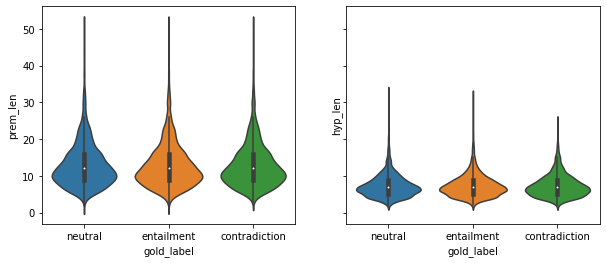

In [6]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

sns.violinplot(x="gold_label", y="prem_len", data=test, scale='count', scale_hue=False, ax=axes[0])
sns.violinplot(x="gold_label", y="hyp_len", data=test, scale='count', scale_hue=False, ax=axes[1])

In [60]:
import seaborn as sns
# how many times are unique sentences repeated in the premise?
dev.premise.value_counts().value_counts()

3    3303
6      15
1       1
Name: premise, dtype: int64

In [22]:
from transformers import MarianMTModel, MarianTokenizer, pipeline
target_model_name = 'Helsinki-NLP/opus-mt-en-roa'
target_tokenizer = MarianTokenizer.from_pretrained(target_model_name)
target_model = MarianMTModel.from_pretrained(target_model_name)
target_pipe = pipeline("text2text-generation", model=target_model, tokenizer=target_tokenizer, framework="pt", device=0)


en_model_name = 'Helsinki-NLP/opus-mt-roa-en'
en_tokenizer = MarianTokenizer.from_pretrained(en_model_name)
en_model = MarianMTModel.from_pretrained(en_model_name)
en_pipe = pipeline("text2text-generation", model=en_model, tokenizer=en_tokenizer, framework="pt", device=0)


In [29]:
def translate(texts, pipe, language="es"):
    template = lambda text: f"{text}" if language == "en" else f">>{language}<< {text}"
    src_texts = [template(text) for text in texts]    
    return [ex['generated_text'] for ex in pipe(src_texts)]


def back_translate(texts, source_lang="en", target_lang="es"):
    # Translate from source to target language
    translated_texts = translate(texts, target_pipe, language=target_lang)

    # Translate from target language back to source language
    back_translated_texts = translate(translated_texts, en_pipe, language=source_lang)
    
    return back_translated_texts


en_texts = ['This is so cool', 'I hated the food', 'They were very helpful']

aug_texts = back_translate(en_texts, source_lang="en", target_lang="es")
print(aug_texts)

['This is so cool.', 'I hated food.', "I've been a great help."]


In [56]:
en_texts = dev.premise.sample(5).to_list()
# process in batches
aug_texts = back_translate(en_texts, source_lang="en", target_lang="fr")


In [57]:
en_texts

['Two people are sitting in a station.',
 "A man and woman, she's dressed all in white, he has a white shirt, holding hands while walking",
 'Two men help an injured player on the field.',
 'A guy looking out over the scenic forest.',
 'An older gentleman standing in front of a washer and dryer with his hand getting ready to push a button and a black basket of clothes sitting on top of the dryer next to him.']

In [58]:
aug_texts

['Two people are roasted in a parking lot.',
 "A man and a woman, she's dressed in white, he's got a white shirt, holding his hands as he walks.",
 'Two men help an injured player in the field.',
 'An uncle watching the scenic forest.',
 'An old gentleman stands up in front of a washing machine and dryer, with his hand, preparing to press a button and a black basket of clothes sitting on top of the dryer on his side.']